In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'hipstr_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [26]:
def add_percentage_of_sites(fdf, cat, lab):
    fdf = fdf.copy()
    fdf = fdf.reset_index()
    dict_maxes = {}
#     fdf['PERC_SITES'] = 0
    dfs = []
    for i,df in fdf.groupby(cat):
        m = df[lab].max()
        inds = df.index.tolist()
        dict_maxes[i] = m
        
        Frac_Max = (df[lab] / m)
        dfs.append(Frac_Max)
    
    t = pd.concat(dfs)
    fdf['PERC_SITES'] = t
    
    return fdf, t   
    

def filtering_df(rr_df, info, cat, subcat_col, thresholds, subcat = False, reverse = False):
    
    def add_num_sites_total(df, info, thresholds, cat, subcat_col=False, subcat=False):
        data = []
        for i in thresholds:
            if subcat:
                s =  info[(info[cat] >= i) & (info[subcat_col] == subcat)].shape[0]
            else:
                s = info[info[cat] >= i].shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby(subcat_col):
        data = []
        for thresh in thresholds:
            if reverse:
                tdf = df[(df[cat] < thresh)]
            else:
                tdf = df[(df[cat] >= thresh)]
            m = tdf.RR.astype(float).mean()
            s = tdf.shape[0]
            data.append([thresh, s, m, g])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'PERIOD'])
        filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, cat, subcat_col=subcat_col, subcat=g)
        dfs.append(filtDf)
    
    # with no subtypes
    data = []
    for thresh in thresholds:
        if reverse:
            tdf = rr_df[(rr_df[cat] < thresh)]
        else:
            tdf = rr_df[(rr_df[cat] >= thresh)]
        m = tdf.RR.astype(float).mean()
        s = tdf.shape[0]
        data.append([thresh, s, m, 'all'])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'PERIOD'])
    filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, cat, subcat=False)
    filtDf = filtDf.pipe(add_percentage_of_sites, 'PERIOD', 'num_sites_all')
    
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
    
    df_out = dfs_out.pipe(add_percentage_of_sites, 'PERIOD', 'num_sites_all')
    
    return df_out 

In [27]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, num_sites, cat, letter_label):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        
        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
        cmap = plt.cm.PuBu
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, cax = axDivY)
        cbar.set_ticks(thresholds)
        
        patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)
        
         
        
        for c, l in zip(colors, labels):
            tdf = df[df.PERIOD == l]
            tdf = tdf.sort_values('thresh')
         
            ax.scatter(tdf[num_sites], tdf.mean_replication_rate, c = tdf.thresh, cmap= cmap, lw = 1, edgecolor = c, label = l, zorder = 10)
            ax.plot(tdf[num_sites], tdf.mean_replication_rate, c = c, lw = 1, zorder = 2)
            
        leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
                             fontsize= 11, title = 'PERIOD', frameon=True, borderaxespad=0)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'mean replication rate', xlabel = 'number of total sites')      
        fig.text(0.98, 0.5, "{} threshold".format(cat), rotation= 90, horizontalalignment='center', verticalalignment='center', fontsize = 15)
        
        
        xlim = ax.get_xlim()
        ax.axhline(0.9, xlim[0], xlim[1], linestyle = '--', )
        
        fig.text(0.05, 0.95, "{}".format(letter_label), horizontalalignment='center', verticalalignment='center', fontsize = 18, fontweight='bold')
        return ax
        
        

In [4]:
def lambda_num_alleles(x):
    spl = x.split(',')
    allele_dict = {i.split(":")[0]: i.split(':')[1] for i in spl}
    
    alleles  = [i for i in allele_dict.keys() if i != './.']
    num_alleles = len(alleles)
    alleles_dist_non_missing = [":".join([i,k]) for i, k in allele_dict.iteritems() if i != './.']
    return num_alleles, ",".join(alleles), ",".join(alleles_dist_non_missing)

In [5]:
def prep_info(df):
    df = df.copy()
    t = df.ALLELES_DIST.apply(lambda x: lambda_num_alleles(x))
    tdf = pd.DataFrame(list(t))
    tdf.columns = ['NUM_ALLELES', 'ALLELES', 'ALLELES_DIST_MOD']
    df = df.join(tdf)
    return df

In [6]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref/hipstr_per_sample_length.tsv'

rr_length_per_pair = pd.read_table(fn)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref/hipstr_per_sample_gt.tsv'

rr_gt_per_pair = pd.read_table(fn)


fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref/hipstr_replication_length_info.tsv'

rr_info_length = pd.read_table(fn)

fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref/hipstr_replication_gt_info.tsv'

rr_info_gt = pd.read_table(fn)

In [7]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref/hipstr_info_dosage.tsv'

info_dosage = pd.read_table(fn).pipe(prep_info)

In [8]:
info_dosage['INFRAME_P_Max'] = info_dosage[['INFRAME_UP', 'INFRAME_DOWN']].max(axis = 1)

In [9]:
rr_info_length['INFRAME_P_Max'] = rr_info_length[['INFRAME_UP', 'INFRAME_DOWN']].max(axis = 1)

# Per Twin Pair RR Percentage

In [10]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14

In [11]:
twin_fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ipscore_sample_info/twins.tsv'
pairs = [line.rstrip().split() for line in open(twin_fn)]   

In [12]:
rr_length_per_pair['Pair'] = ["_".join(p) for p in pairs]
rr_gt_per_pair['Pair'] = ["_".join(p) for p in pairs]

# With no filtering

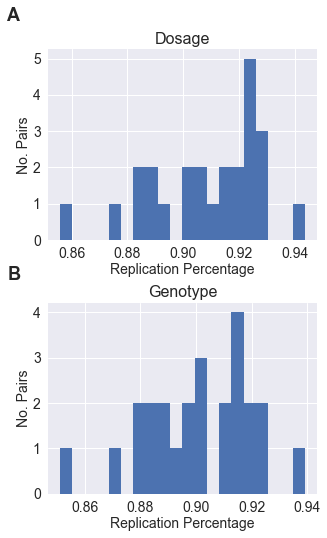

In [13]:
fig, ax = plt.subplots(2,1, figsize = (5,8))
ax1 = ax[0]
ax2 = ax[1]

rr_length_per_pair.RR.hist(bins = 20, ax = ax1)
rr_gt_per_pair.RR.hist(bins = 20, ax = ax2)
ax1.set(xlabel='Replication Percentage', ylabel = 'No. Pairs')
ax2.set(xlabel='Replication Percentage', ylabel = 'No. Pairs')

ax1.set_title('Dosage')
ax2.set_title('Genotype')

fig.text(0.05, 0.95, 'A', weight = 'bold', fontsize = 18)
fig.text(0.05, 0.5, 'B', weight = 'bold', fontsize = 18)


plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])



# Distributions of various parameters of the VCF

In [16]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10

In [17]:
params = ['PERIOD', 'FRAC_DP', 'FRAC_DSTUTTER', 'FRAC_DFLANKINDEL','NREF', 'NUM_ALLELES', 'INFRAME_UP', 'INFRAME_DOWN']

In [19]:
info_dosage.shape

(946036, 29)

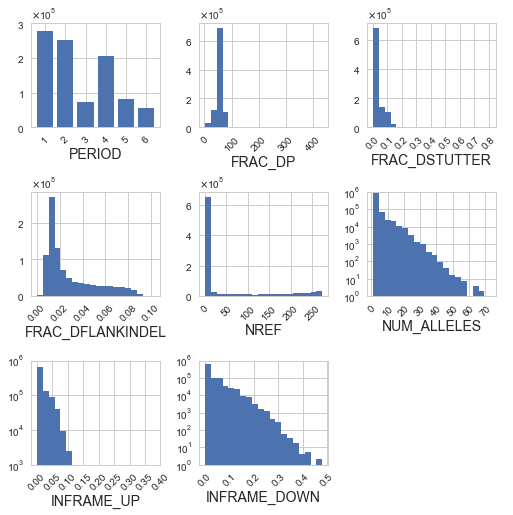

In [23]:
# with plt.rc_context({'axes.autolimit_mode': 'data'}):
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,3, figsize = (8,8), dpi = 1000)
    ax1 = ax[0]
    ax2 = ax[1]

    tick_original = ticker.MaxNLocator(nbins=15, steps=[1, 2, 5,10])

    axes = fig.get_axes()


    for i, p in enumerate(params):
        hax = axes[i]
        
        if p == 'PERIOD':
            vc = info_dosage[p].value_counts()
            
            hax.bar(vc.index.tolist(), vc.tolist())
            hax.set_ylim(0,300000)
        else:
            hax.hist(info_dosage[p], bins = 20)

        hax.ticklabel_format(axis ='y', style='sci', scilimits = (0,0), useMathText = True)
        hax.tick_params(axis ='x', labelrotation=45)
        
        hax.xaxis.set_major_locator(ticker.MaxNLocator(nbins= 9,steps = [1, 2, 5,10], min_n_ticks = 4))
        hax.set_xlabel(p)
        
        
    
    hax = ax[0][1]
    #     hax.set_xl

    hax = ax[2][0]
    hax.set_yscale('log')
    hax.set_yticks([1000, 10000, 100000, 1000000])
    hax.set_ylim(1000, 1000000)
    hax.minorticks_off()
    # hax.yaxis.set_major_locator(ticker.LogLocator(numticks=10))
    #     hax.set_ylim(10000, 1000000)

    hax = ax[2][1]

    hax.set_yscale('log', )
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.minorticks_off()
    hax.set_ylim(1, 1000000)
    
    
    hax = ax[1][2]
    hax.set_yscale('log')
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.set_ylim(0, 1000000)
    hax.minorticks_off()
    
    hax = ax[2][2]
    hax.set_axis_off()

    plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])


In [25]:
info_dosage.FRAC_DP.describe()

count    946036.000000
mean         54.996163
std          12.543738
min           2.144700
25%          49.737575
50%          57.237700
75%          62.827200
max         432.761900
Name: FRAC_DP, dtype: float64

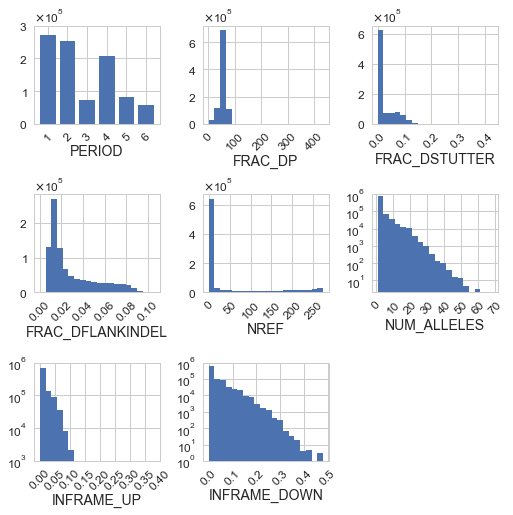

In [177]:
# with plt.rc_context({'axes.autolimit_mode': 'data'}):
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(3,3, figsize = (8,8), dpi = 1000)
    ax1 = ax[0]
    ax2 = ax[1]

    tick_original = ticker.MaxNLocator(nbins=15, steps=[1, 2, 5,10])

    axes = fig.get_axes()


    for i, p in enumerate(params):
        hax = axes[i]
        
        if p == 'PERIOD':
            vc = info_dosage[p].value_counts()
            
            hax.bar(vc.index.tolist(), vc.tolist())
            hax.set_ylim(0,300000)
        else:
            hax.hist(info_dosage[p], bins = 20)

        hax.ticklabel_format(axis ='y', style='sci', scilimits = (0,0), useMathText = True)
        hax.tick_params(axis ='x', labelrotation=45)
        
        hax.xaxis.set_major_locator(ticker.MaxNLocator(nbins= 9,steps = [1, 2, 5,10], min_n_ticks = 4))
        hax.set_xlabel(p)
        
        
    
    hax = ax[0][1]
    #     hax.set_xl

    hax = ax[2][0]
    hax.set_yscale('log')
    hax.set_yticks([1000, 10000, 100000, 1000000])
    hax.set_ylim(1000, 1000000)
    hax.minorticks_off()
    # hax.yaxis.set_major_locator(ticker.LogLocator(numticks=10))
    #     hax.set_ylim(10000, 1000000)

    hax = ax[2][1]

    hax.set_yscale('log', )
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.minorticks_off()
    hax.set_ylim(1, 1000000)
    
    
    hax = ax[1][2]
    hax.set_yscale('log')
    hax.set_yticks([1,10, 100, 1000, 10000, 100000, 1000000])
    hax.set_ylim(0, 1000000)
    hax.minorticks_off()
    
    hax = ax[2][2]
    hax.set_axis_off()

    plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])


In [170]:
t = info_dosage.PERIOD.value_counts()

<Container object of 6 artists>

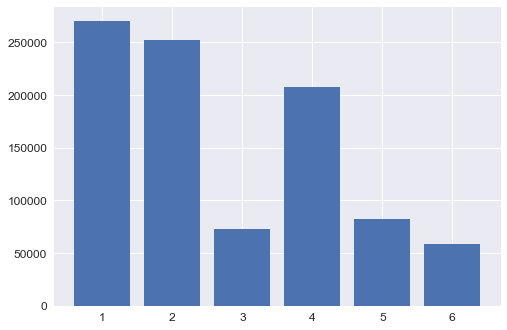

In [175]:
plt.bar(t.index.tolist(), t.tolist())

In [20]:
thresholds = np.arange(0, 100, 5)

fdf = filtering_df(rr_info_length, info_dosage, 'FRAC_DP', thresholds)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


In [22]:
rr_info_length.groupby('PERIOD').RR.mean()

PERIOD
1    0.872042
2    0.889933
3    0.876725
4    0.968933
5    0.900472
6    0.794021
Name: RR, dtype: float64

In [95]:
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12

In [164]:
info_dosage[info_dosage.NUM_ALLELES

(944505, 28)

In [165]:
info_dosage[info_dosage.]

count    944505.000000
mean          3.099860
std           3.947823
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          68.000000
Name: NUM_ALLELES, dtype: float64

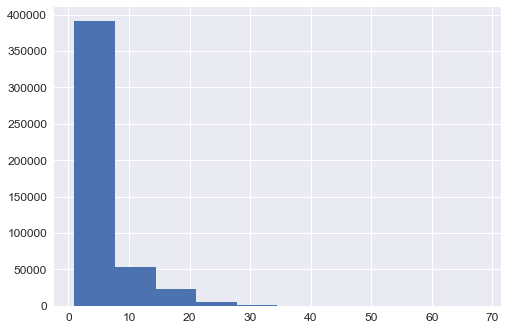

In [168]:
info_dosage[info_dosage.NREF > 0].NUM_ALLELES.hist()

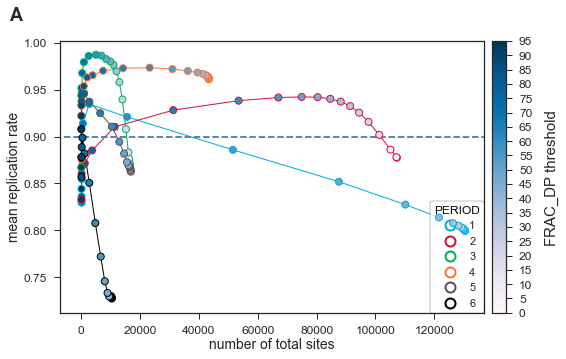

In [148]:
ax = plot_discordance_vs_cat(fdf, labels[:-1], colors[:-1], thresholds, 'num_sites', 'FRAC_DP', 'A')
# ax.set_xlim(-2000,150000)

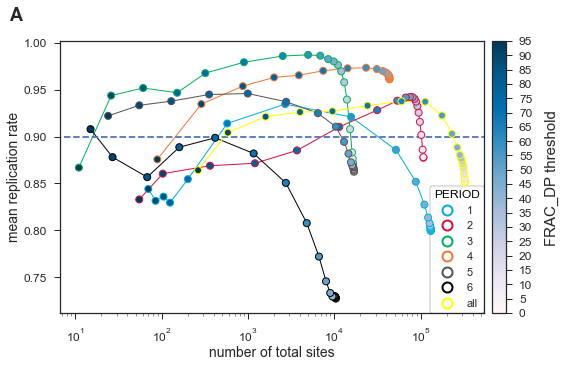

In [149]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'FRAC_DP', 'A')
ax.set_xscale('log')
# ax.tick_params(which = 'both', labelsize= 20, )

In [150]:
thresholds = np.arange(0, 0.22, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'PERC_MISSING', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


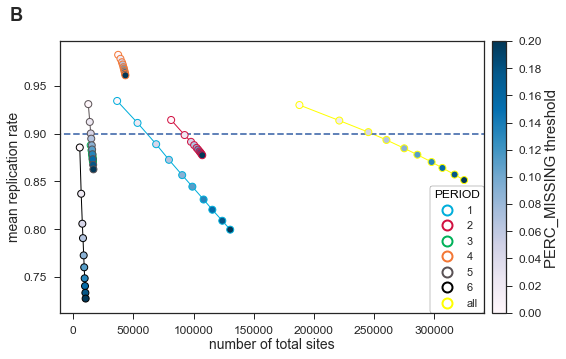

In [151]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'PERC_MISSING', 'B')

In [152]:
thresholds = np.arange(0, 0.22, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'FRAC_DSTUTTER', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


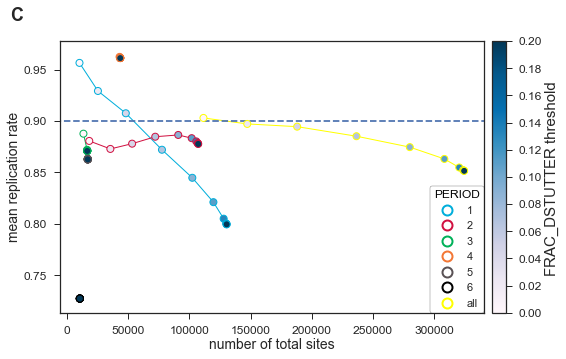

In [153]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'FRAC_DSTUTTER', 'C')

In [154]:
thresholds = np.arange(0, 0.22, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'INFRAME_UP', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']


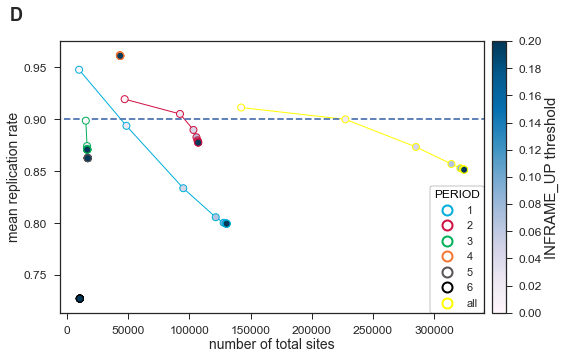

In [156]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'INFRAME_UP', 'D')

In [195]:
thresholds = np.arange(0, 0.5, 0.02)

fdf_down = filtering_df(rr_info_length, info_dosage, 'INFRAME_DOWN', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

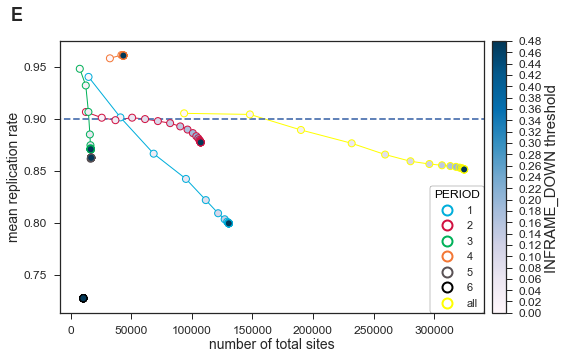

In [197]:
ax = plot_discordance_vs_cat(fdf_down, labels, colors, thresholds, 'num_sites', 'INFRAME_DOWN', 'E')

In [191]:
thresholds = np.arange(0, 0.5, 0.02)

fdf = filtering_df(rr_info_length, info_dosage, 'INFRAME_P_Max', thresholds, reverse=True)

colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black', 'yellow']
labels = [1, 2, 3 , 4,5,6, 'all']

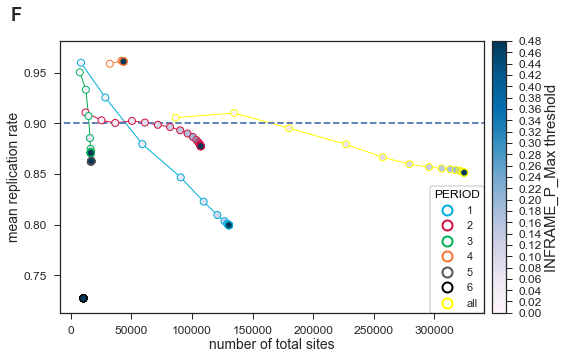

In [193]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds, 'num_sites', 'INFRAME_P_Max', 'F')